<a href="https://colab.research.google.com/github/tosmeley/project_folder/blob/main/week_12_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-30 03:44:26--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.232.248, 52.217.99.230, 52.217.137.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.232.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.9MB/s    in 0.7s    

2022-11-30 03:44:27 (18.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
#Inspecting the data  of the Jena weather dataset

In [ ]:
import os
fname=os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data=f.read()

lines=data.split("\n")
header=lines[0].split(",")
lines=lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
# Parsing the data

import numpy as np
temperature = np.zeros ((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",") [1:]]
    temperature[i]= values[1]
    raw_data[i,:] = values[:]


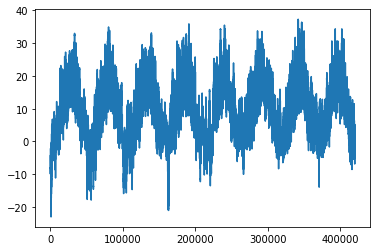

In [ ]:
# Plotting the temperature timeseries
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)) , temperature)

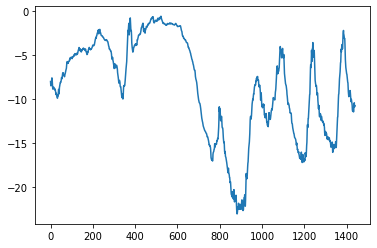

In [ ]:
#Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temperature[:1440])


In [ ]:
#Computing the number of samples we'll use for each data split
num_train_samples = int(0.5 * len(raw_data))
num_val_samples=int(0.25 * len(raw_data))
num_test_samples=len(raw_data)-num_train_samples-num_val_samples
print("num_train_samples:",num_train_samples)
print("num_val_samples: ",num_val_samples)
print("num_test_samples:",num_test_samples)

num_train_samples: 210225
num_val_samples:  105112
num_test_samples: 105114


In [ ]:
#Preparing the data
#Normalizing the data

mean=raw_data[:num_train_samples].mean(axis=0)
raw_data-= mean
std= raw_data[:num_train_samples].std(axis=0)
raw_data /= std


In [ ]:
import numpy as np
from tensorflow import keras
int_sequence=np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:1],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))


In [ ]:
#Instantiating datasets for training,validation,and testing
sampling_rate = 6
sequence_length = 120
delay= sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset= keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
#Inspecting the output of one of our datasets

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
#A common-sense, non-machine-learning baseline
#Computing the common-sense baseline MAE
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [ ]:
# Let's try a basic machine-learning model
# Training and evaluating a densely connected model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 40s 46ms/step - loss: 12.9394 - mae: 2.7859 - val_loss: 10.5504 - val_mae: 2.5729
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 9.2331 - mae: 2.3912 - val_loss: 10.1761 - val_mae: 2.5023
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.4383 - mae: 2.2854 - val_loss: 10.4735 - val_mae: 2.5521
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 7.9615 - mae: 2.2207 - val_loss: 9.9375 - val_mae: 2.4954
Epoch 5/10
819/819 [==============================] - 38s 47ms/step - loss: 7.6809 - mae: 2.1825 - val_loss: 15.1508 - val_mae: 3.1085
Epoch 6/10
819/819 [==============================] - 37s 45ms/step - loss: 7.4466 - mae: 2.1492 - val_loss: 10.8571 - val_mae: 2.6050
Epoch 7/10
819/819 [==============================] - 38s 46ms/step - loss: 7.2631 - mae: 2.1224 - val_loss: 10.6363 - val_mae: 2.5759
Epoch 8/10
819/819 [==============================] - 4

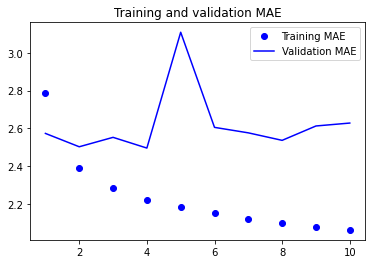

In [ ]:
#Plotting results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
#Let's try a 1D convolutional model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 48ms/step - loss: 22.1510 - mae: 3.7020 - val_loss: 15.7431 - val_mae: 3.1210
Epoch 2/10
819/819 [==============================] - 39s 48ms/step - loss: 15.3903 - mae: 3.1064 - val_loss: 16.2904 - val_mae: 3.1784
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 14.0777 - mae: 2.9651 - val_loss: 15.4193 - val_mae: 3.1098
Epoch 4/10
819/819 [==============================] - 39s 48ms/step - loss: 13.3078 - mae: 2.8783 - val_loss: 14.8288 - val_mae: 3.0420
Epoch 5/10
819/819 [==============================] - 40s 48ms/step - loss: 12.7211 - mae: 2.8143 - val_loss: 15.3998 - val_mae: 3.0740
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 12.2016 - mae: 2.7564 - val_loss: 16.3276 - val_mae: 3.1895
Epoch 7/10
819/819 [==============================] - 39s 48ms/step - loss: 11.7555 - mae: 2.7051 - val_loss: 16.8807 - val_mae: 3.2298
Epoch 8/10
819/819 [============================

In [ ]:
# A first recurrent baseline
# A simple LSTM-based model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 52ms/step - loss: 37.7141 - mae: 4.4524 - val_loss: 12.5443 - val_mae: 2.6805
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 10.8362 - mae: 2.5622 - val_loss: 10.0134 - val_mae: 2.4348
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 9.9131 - mae: 2.4580 - val_loss: 9.4558 - val_mae: 2.3912
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 9.5601 - mae: 2.4134 - val_loss: 9.5443 - val_mae: 2.3972
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 9.3295 - mae: 2.3822 - val_loss: 9.5500 - val_mae: 2.3942
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 9.0638 - mae: 2.3490 - val_loss: 9.5925 - val_mae: 2.4119
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 8.9009 - mae: 2.3293 - val_loss: 9.5256 - val_mae: 2.3911
Epoch 8/10
819/819 [==============================] - 43s 

In [ ]:
# Understanding recurrent neural networks
# NumPy implementation of a simple RNN
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [ ]:
# A recurrent layer in Keras
# An RNN layer that can process sequences of any length
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [ ]:
# An RNN layer that returns only its last output step
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [ ]:
# An RNN layer that returns its full output sequence
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [ ]:
# Stacking RNN layers
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In [ ]:
# Advanced use of recurrent neural networks
# Using recurrent dropout to fight overfitting
# Training and evaluating a dropout-regularized LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 339s 411ms/step - loss: 26.3163 - mae: 3.7986 - val_loss: 9.9748 - val_mae: 2.4449
Epoch 2/50
819/819 [==============================] - 339s 414ms/step - loss: 14.7722 - mae: 2.9818 - val_loss: 9.7241 - val_mae: 2.4186
Epoch 3/50
819/819 [==============================] - 340s 415ms/step - loss: 14.0165 - mae: 2.8982 - val_loss: 9.5472 - val_mae: 2.3967
Epoch 4/50
819/819 [==============================] - 339s 414ms/step - loss: 13.5298 - mae: 2.8474 - val_loss: 9.5327 - val_mae: 2.4045
Epoch 5/50
819/819 [==============================] - 339s 414ms/step - loss: 12.9345 - mae: 2.7870 - val_loss: 10.0187 - val_mae: 2.4458
Epoch 6/50
819/819 [==============================] - 339s 414ms/step - loss: 12.5770 - mae: 2.7453 - val_loss: 10.3185 - val_mae: 2.4881
Epoch 7/50
819/819 [==============================] - 341s 416ms/step - loss: 12.2230 - mae: 2.7092 - val_loss: 9.9210 - val_mae: 2.4446
Epoch 8/50
819/819 [===================

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

In [ ]:
# Stacking recurrent layers
# Training and evaluating a dropout-regularized, stacked GRU model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:

# Using bidirectional RNNs
# Training and evaluating a bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)